## Plantão 14/09/2021 


Profa. **Cibele Russo**

**MBA em Ciências de Dados**

O arquivo flightsearch.csv contém dados de pesquisas com o termo "flight" no Google nos últimos cinco anos. Fonte: https://trends.google.com.br/trends/explore?date=today%205-y&geo=US&q=flight

1. Faça a leitura dos dados, estabeleça um índice por datas. Faça a visualização dos dados com gráfico de linhas e boxplots por semanas. Há evidências de estacionariedade nos gráficos? Por quê?


2. Proponha uma decomposição dos dados confirmados em tendência e sazonalidade. Comente as componentes de tendência, sazonalidade e resíduos. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Esses resultados indicam a presença de autocorrelação? Justifique.


3. Divida a série de registros confirmados em treinamento e teste, com 50 observações na base de teste. A que se referem os dados de treinamento e teste e como essa divisão contribui para a análise de modelos preditivos? 


4. Utilizando a base de treinamento de registros de buscas pelo termo "flight", obtenha:

    - As previsões de Holt Winters.
    
    - As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido para a variável confirmed. Identifique a natureza das componentes desse melhor modelo (por exemplo, “o modelo componentes autorregressiva não sazonal, componente de médias móveis sazonal", etc).
    
    - As previsões com o método Theta usual.
    
    - As previsões com um modelo de redes neurais recorrentes.
    
    

5. Utilize o erro absoluto médio para comparar as previsões obtidas com as observações da base de teste. Escolha o método que produz as melhores previsões. Justifique sua resposta. Represente em um mesmo gráfico a base de treinamento, de teste e as previsões obtidas pelos quatro métodos.


6. Repita com 10, 30, 75 observações na base de teste e compare os métodos em relação à predição.


## Item 1

1. Faça a leitura dos dados, estabeleça um índice por datas. Faça a visualização dos dados com gráfico de linhas (com dados semanais) e boxplots por meses. Há evidências de estacionariedade nos gráficos? Por quê?




In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

pkgdir = '/hdd/MBA/AprendizadoDinamico/Data'

plt.rcParams['figure.figsize'] = [12,6]

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(f'{pkgdir}/flightsearch.csv', index_col=0, parse_dates=True)

df.head()


,flight: (Todo o mundo)
Semana,
2016-09-18,67
2016-09-25,67
2016-10-02,69
2016-10-09,67
2016-10-16,67


In [3]:
df.index

DatetimeIndex(['2016-09-18', '2016-09-25', '2016-10-02', '2016-10-09',
               '2016-10-16', '2016-10-23', '2016-10-30', '2016-11-06',
               '2016-11-13', '2016-11-20',
               ...
               '2021-07-04', '2021-07-11', '2021-07-18', '2021-07-25',
               '2021-08-01', '2021-08-08', '2021-08-15', '2021-08-22',
               '2021-08-29', '2021-09-05'],
              dtype='datetime64[ns]', name='Semana', length=260, freq=None)

In [4]:
df.index.freq = 'W'
df.index

DatetimeIndex(['2016-09-18', '2016-09-25', '2016-10-02', '2016-10-09',
               '2016-10-16', '2016-10-23', '2016-10-30', '2016-11-06',
               '2016-11-13', '2016-11-20',
               ...
               '2021-07-04', '2021-07-11', '2021-07-18', '2021-07-25',
               '2021-08-01', '2021-08-08', '2021-08-15', '2021-08-22',
               '2021-08-29', '2021-09-05'],
              dtype='datetime64[ns]', name='Semana', length=260, freq='W-SUN')

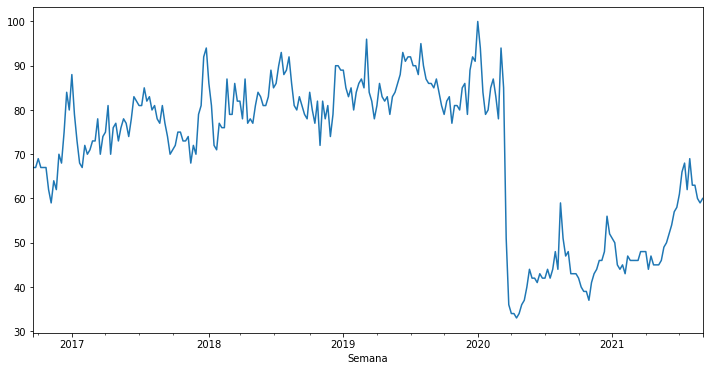

In [5]:
df['flight: (Todo o mundo)'].plot();

**Boxplots por mês**

In [6]:
df.index.month

Int64Index([ 9,  9, 10, 10, 10, 10, 10, 11, 11, 11,
            ...
             7,  7,  7,  7,  8,  8,  8,  8,  8,  9],
           dtype='int64', name='Semana', length=260)

In [7]:
df.index.month + (df.index.year - df.index.year.min()) * 12 - df.index.month[0]

Int64Index([ 0,  0,  1,  1,  1,  1,  1,  2,  2,  2,
            ...
            58, 58, 58, 58, 59, 59, 59, 59, 59, 60],
           dtype='int64', name='Semana', length=260)

<AxesSubplot:xlabel='mês', ylabel='flight: (Todo o mundo)'>

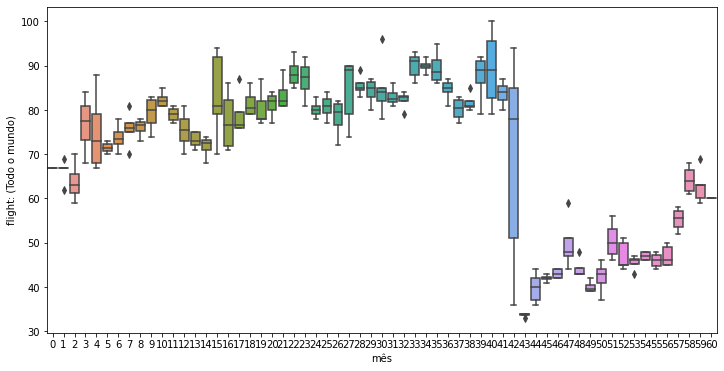

In [8]:
import seaborn as sns

df['mês'] = df.index.month + (df.index.year - df.index.year.min()) * 12 - df.index.month[0]

sns.boxplot(x=df['mês'], y=df['flight: (Todo o mundo)'])

In [9]:
# Obs: Caso fosse necessário consolidar os dados por mês

df2 = df.groupby(by=df['mês'], axis=0).agg({'flight: (Todo o mundo)':'sum'})
df2.head()

,flight: (Todo o mundo)
mês,
0,134
1,332
2,255
3,307
4,375


## Item 2

2. Proponha uma decomposição das buscas em tendência e sazonalidade. Comente as componentes de tendência, sazonalidade e resíduos. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Esses resultados indicam a presença de autocorrelação? Justifique.



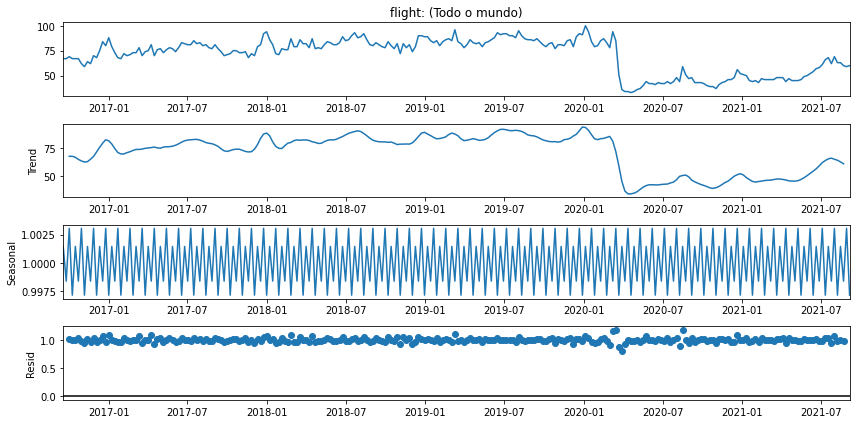

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot


result = seasonal_decompose(df['flight: (Todo o mundo)'], model='multiplicative', period=4)
result.plot()

pyplot.show()

In [11]:
sdecomp = seasonal_decompose(df['flight: (Todo o mundo)'], model='multiplicative', period=4)

<AxesSubplot:xlabel='Semana'>

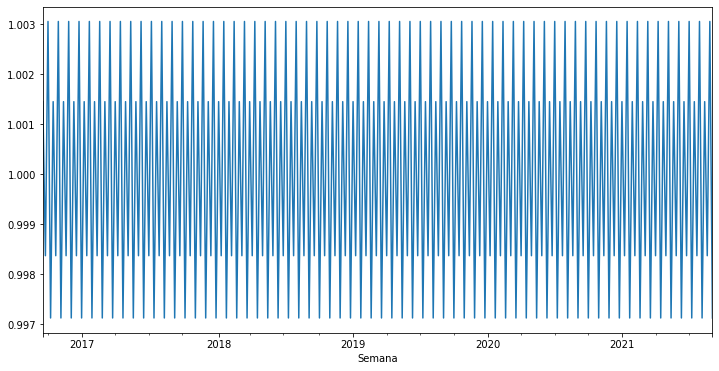

In [12]:
sdecomp.seasonal.plot()

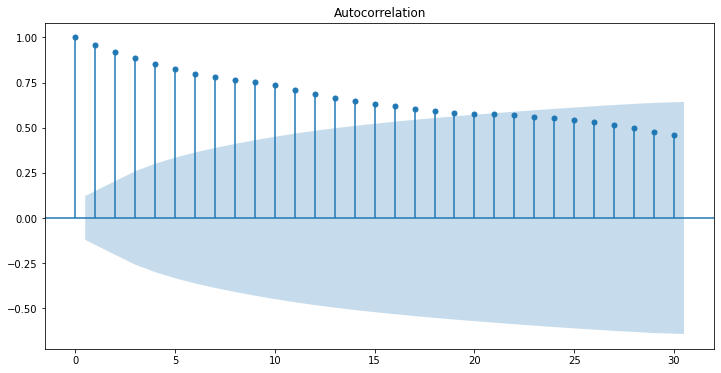

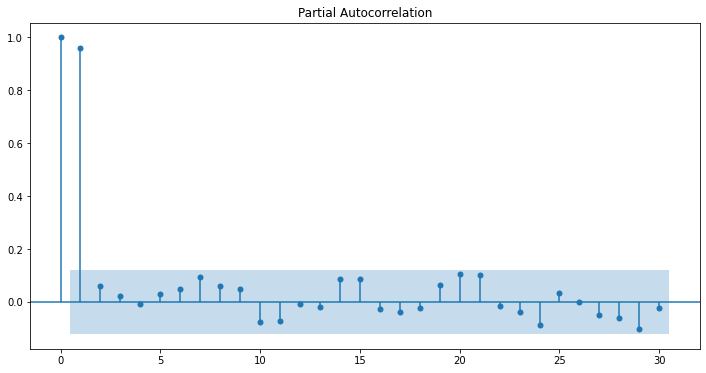

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 

# Correlograma

plot_acf(df['flight: (Todo o mundo)'], lags=30)
plot_pacf(df['flight: (Todo o mundo)'], lags=30)
plt.show()

<AxesSubplot:xlabel='Semana'>

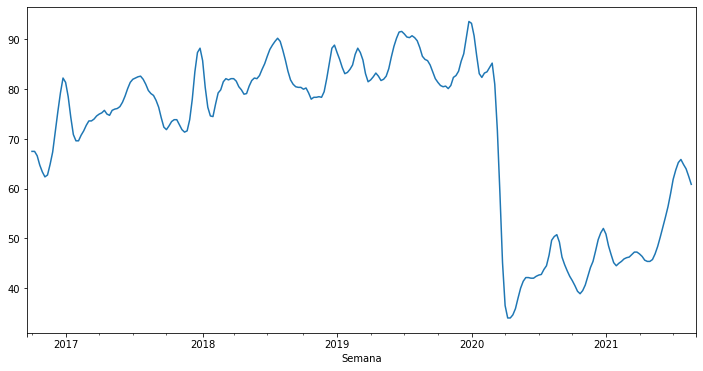

In [14]:
result.trend.plot()

## Item 3

3. Divida a série de registros confirmados em treinamento e teste, com 50 observações na base de teste. A que se referem os dados de treinamento e teste e como essa divisão contribui para a análise de modelos preditivos?

In [15]:
tam_base_teste = 50

In [16]:
len(df) - tam_base_teste

210

In [17]:
df_treino = df.iloc[:(len(df) - tam_base_teste)] # Dados de treinamento 
df_teste = df.iloc[len(df) - tam_base_teste:] # Dados de teste 

In [18]:
df_teste.head()

,flight: (Todo o mundo),mês
Semana,,
2020-09-27,43,48
2020-10-04,42,49
2020-10-11,40,49
2020-10-18,39,49
2020-10-25,39,49


## Item 4

4. Utilizando a base de treinamento de registros de buscas pelo termo "flight", obtenha:

    - As previsões de Holt Winters.
    
    - As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido para a variável confirmed. Identifique a natureza das componentes desse melhor modelo (por exemplo, “o modelo componentes autorregressiva não sazonal, componente de médias móveis sazonal", etc).
    
    - As previsões com o método Theta usual.
    
    - As previsões com um modelo de redes neurais recorrentes (LSTM ou GRU).    

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ajustado_HW = ExponentialSmoothing(df_treino['flight: (Todo o mundo)'],trend='multiplicative',seasonal='multiplicative',seasonal_periods=4).fit()
predito_HW = ajustado_HW.forecast(len(df_teste)).rename('Previsão Holt-Winters')

df_teste['Holt-Winters'] = predito_HW


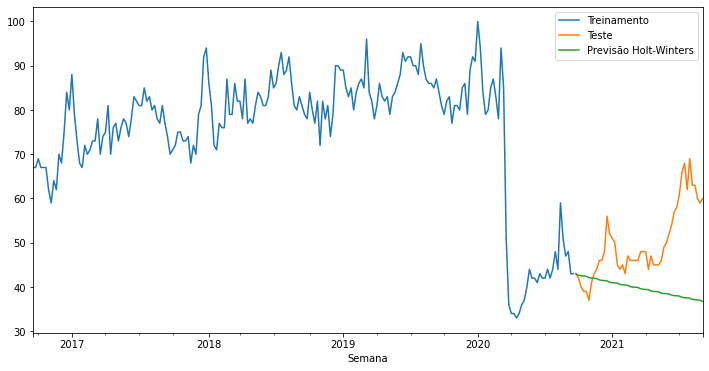

In [20]:
df_treino['flight: (Todo o mundo)'].plot(legend=True,label='Treinamento',figsize=(12,6))
df_teste['flight: (Todo o mundo)'].plot(legend=True,label='Teste')
predito_HW.plot(legend=True,label='Previsão Holt-Winters');



In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima  

In [22]:
# Ajuste de modelo SARIMA 

stepwise_fit = auto_arima(df_treino['flight: (Todo o mundo)'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=4,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=1301.408, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1297.903, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1300.354, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1300.169, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1295.999, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=1299.541, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=1299.520, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=1298.804, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=1298.678, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1296.997, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.376 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -647.000
Date:                Tue, 14 Sep 2021   AIC                           1295.999
Time:                        22:29:15   BIC                           1299.342
Sample:                             0   HQIC                          1297.351
                                - 210                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        28.6029      1.296     22.066      0.000      26.062      31.143
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               491.40
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -1.00
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
modelo = SARIMAX(df_treino['flight: (Todo o mundo)'], order=(1,1,1), seasonal_order=(0,0,0,4))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     flight: (Todo o mundo)   No. Observations:                  210
Model:                   SARIMAX(1, 1, 1)   Log Likelihood                -644.670
Date:                    Tue, 14 Sep 2021   AIC                           1295.340
Time:                            22:29:15   BIC                           1305.367
Sample:                        09-18-2016   HQIC                          1299.394
                             - 09-20-2020                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8148      0.143      5.702      0.000       0.535       1.095
ma.L1         -0.9019      0.131     -6.889      0.000      -1.158      -0.645
sigma2        27.9572      1.259     22.212      0.000      25.490      30.424
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               567.75
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
inicio=len(df_treino)
fim=len(df_treino)+len(df_teste)-1
previsões = resultado.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsões SARIMA')
previsões.index = df_teste.index

In [25]:
df_teste['SARIMA'] = previsões 

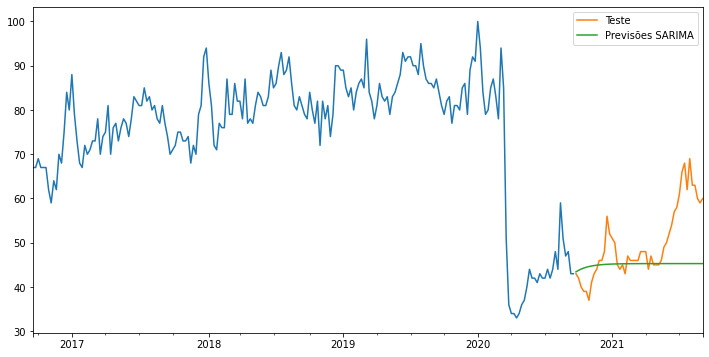

In [26]:
# Plot predictions against known values
title = ''
ylabel=''
xlabel=''

df_treino['flight: (Todo o mundo)'].plot()
ax = df_teste['flight: (Todo o mundo)'].plot(legend=True,figsize=(12,6),title=title, label='Teste')

previsões.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [27]:
from statsmodels.tsa.forecasting.theta import ThetaModel

res = ThetaModel(df_treino['flight: (Todo o mundo)'], deseasonalize=True, period=4).fit()
fcast = res.forecast(len(df_teste))

df_teste['Theta'] = np.array(fcast)

In [28]:
train = pd.DataFrame(df_treino['flight: (Todo o mundo)'])
test = pd.DataFrame(df_teste['flight: (Todo o mundo)'])

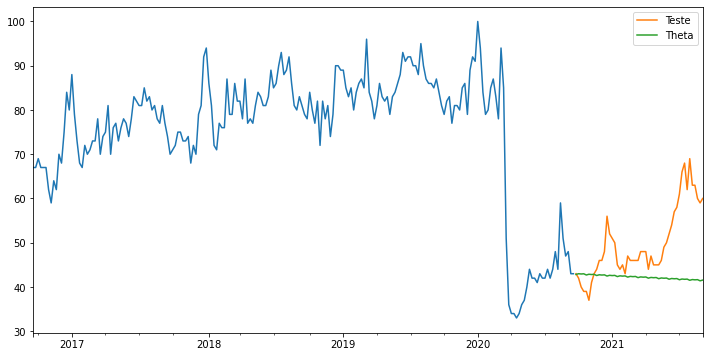

In [29]:
# Plot predictions against known values
title = ''
ylabel=''
xlabel=''

df_treino['flight: (Todo o mundo)'].plot()
ax = df_teste['flight: (Todo o mundo)'].plot(legend=True,figsize=(12,6),title=title, label='Teste')

df_teste['Theta'].plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [31]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)


In [42]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 8
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

Epoch 1/200
101/101 [==============================] - 1s 2ms/step - loss: 0.0653
Epoch 2/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 3/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 4/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 5/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 7/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 8/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 9/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 10/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 11/200
101/101 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 12/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 13/200


101/101 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 197/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 198/200
101/101 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 199/200
101/101 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 200/200
101/101 [==============================] - 0s 2ms/step - loss: 0.0056


array([[0.14925373],
       [0.13432836],
       [0.10447761],
       [0.08955224],
       [0.08955224],
       [0.05970149],
       [0.11940299],
       [0.14925373],
       [0.1641791 ],
       [0.19402985],
       [0.19402985],
       [0.2238806 ],
       [0.34328358],
       [0.28358209],
       [0.26865672],
       [0.25373134],
       [0.17910448],
       [0.1641791 ],
       [0.17910448],
       [0.14925373],
       [0.20895522],
       [0.19402985],
       [0.19402985],
       [0.19402985],
       [0.19402985],
       [0.2238806 ],
       [0.2238806 ],
       [0.2238806 ],
       [0.1641791 ],
       [0.20895522],
       [0.17910448],
       [0.17910448],
       [0.17910448],
       [0.19402985],
       [0.23880597],
       [0.25373134],
       [0.28358209],
       [0.31343284],
       [0.35820896],
       [0.37313433],
       [0.41791045],
       [0.49253731],
       [0.52238806],
       [0.43283582],
       [0.53731343],
       [0.44776119],
       [0.44776119],
       [0.402

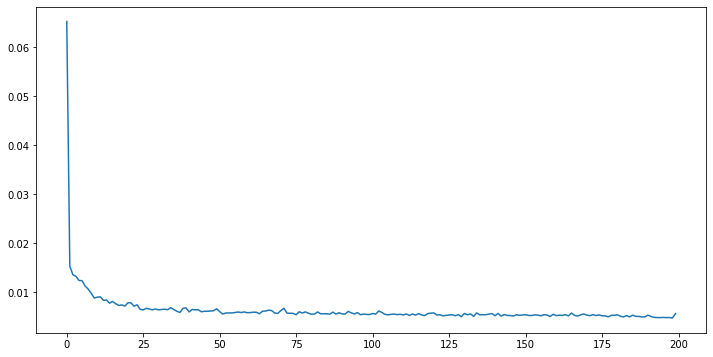

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

n_features = 1

# Defina o modelo
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# Ajuste do modelo
model.fit(generator,epochs=200)

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)


# Agora vamos considerar as previsões para as próximas 21 observações e comparar com a base de teste
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

test_predictions

scaled_test

In [44]:
df_teste['LSTM'] = scaler.inverse_transform(test_predictions)

## Item 5

5. Utilize o erro absoluto médio para comparar as previsões obtidas com as observações da base de teste. Escolha o método que produz as melhores previsões. Justifique sua resposta. Represente em um mesmo gráfico a base de treinamento, de teste e as previsões obtidas pelos quatro métodos.

In [45]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [46]:
mean_absolute_error(df_teste['flight: (Todo o mundo)'],df_teste['Holt-Winters'])

10.724966653006954

In [47]:
mean_absolute_error(df_teste['flight: (Todo o mundo)'],df_teste['SARIMA'])

6.240563430017196

In [48]:
mean_absolute_error(df_teste['flight: (Todo o mundo)'],df_teste['Theta'])

8.365865048910443

In [49]:
mean_absolute_error(df_teste['flight: (Todo o mundo)'],df_teste['LSTM'])

4.086931747794151

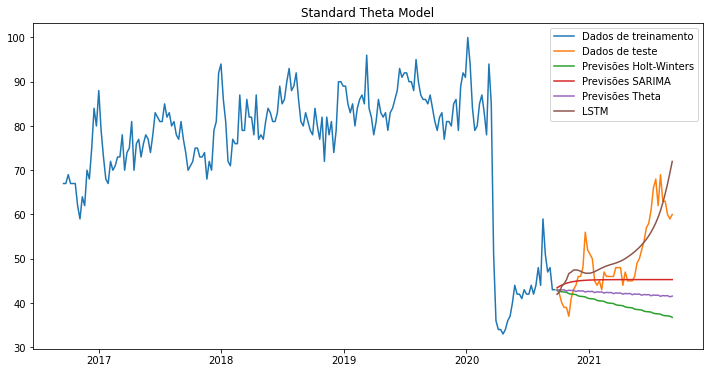

In [50]:
plt.plot(df_treino['flight: (Todo o mundo)'], label = 'Dados de treinamento')
plt.plot(df_teste['flight: (Todo o mundo)'], label = 'Dados de teste')
plt.plot(df_teste['Holt-Winters'], label = 'Previsões Holt-Winters')
plt.plot(df_teste['SARIMA'], label = 'Previsões SARIMA')
plt.plot(df_teste['Theta'], label = 'Previsões Theta')
plt.plot(df_teste['LSTM'], label = 'LSTM')
            
plt.title('Standard Theta Model')
plt.legend()
plt.show()